Compiling model...
Building feed-forward neural network...
'build' took 0.119771 s

'compile' took 2.299255 s

Initializing variables...
Training model...

0         [5.93e-02, 1.29e+00, 3.47e-02]    [5.93e-02, 1.29e+00, 3.47e-02]    []  
1000      [2.30e-02, 1.62e-02, 4.57e-02]    [2.30e-02, 1.62e-02, 4.57e-02]    []  
2000      [1.88e-02, 1.19e-02, 3.81e-02]    [1.88e-02, 1.19e-02, 3.81e-02]    []  
3000      [1.54e-02, 1.18e-02, 3.29e-02]    [1.54e-02, 1.18e-02, 3.29e-02]    []  
4000      [9.28e-03, 3.05e-03, 2.27e-02]    [9.28e-03, 3.05e-03, 2.27e-02]    []  
5000      [8.97e-03, 2.89e-03, 2.32e-02]    [8.97e-03, 2.89e-03, 2.32e-02]    []  
6000      [6.30e-03, 2.00e-03, 1.47e-02]    [6.30e-03, 2.00e-03, 1.47e-02]    []  
7000      [5.52e-03, 1.63e-03, 1.46e-02]    [5.52e-03, 1.63e-03, 1.46e-02]    []  
8000      [5.41e-03, 1.40e-03, 1.45e-02]    [5.41e-03, 1.40e-03, 1.45e-02]    []  
9000      [5.69e-03, 1.31e-03, 1.27e-02]    [5.69e-03, 1.31e-03, 1.27e-02]    []  
10000     [4.1

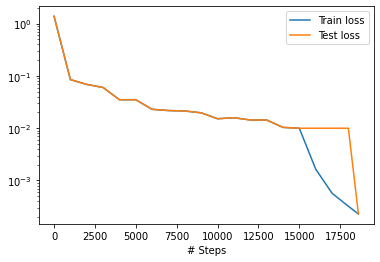

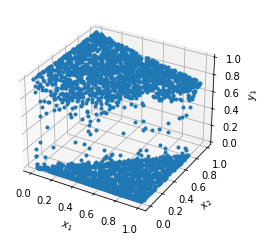

Mean residual: 0.011544601
L2 relative error: 0.11592316


In [15]:
"""Backend supported: tensorflow.compat.v1, tensorflow, pytorch"""
import deepxde as dde
import numpy as np
import sys
sys.path.insert(0, '/home/ppiper/MEGA/github/IM458-B/twoPhaseFlow')
import twoPhaseFlow as tpf


def gen_testdata():
    data = np.load("./dataset/Burgers.npz")
    t, x, exact = data["t"], data["x"], data["usol"].T
    xx, tt = np.meshgrid(x, t)
    X = np.vstack((np.ravel(xx), np.ravel(tt))).T
    y = exact.flatten()[:, None]
    return X, y

def chunks(l, n):
    n = max(1, n)
    return [l[i:i+n] for i in range(0, len(l), n)]

def chunks_multiply(l, n, t):
    n = max(1, n)
    for j,i in enumerate(range(0, len(l), n)): l[i:i+n]=l[i:i+n]*t[j] 
    return l

def chunks_copy(l, n, x):
    n = max(1, n)
    for i in range(0, len(l), n): l[i:i+n]=x
    return l

def impulse_like(vec):
    imp = np.zeros_like(vec)
    imp[0]=1.0
    return imp

N = 256
x_ = np.linspace(0, 1, N)
Nt = 100
t_ = np.linspace(0, 0.99, Nt)

def solve_exact(f, x, t, M):
    # f = tpf.u_convex
    u = tpf.u_solve(f, x, t, M)

    u = u.flatten()
    u = u.reshape((len(u),1))

    t_ = np.ones(len(u))
    t = chunks_multiply(t_, N, t)

    X = np.zeros_like(t)
    X = chunks_copy(X, N, x)

    X = np.stack((X,t),axis=1)

    return X, u


#M = 2
#def f(u):
#    #concave
#    return u/(u+(1-u)/M)

#M = 1 
#def f(u):
#    # convex
#    return u**2

M = 1.0
def f(u):
    #non convex
    return u**2.0/(u**2.0+(1.0-u)**2.0/M)

#def pde(x, y):
#    dy_x = dde.grad.jacobian(y, x, i=0, j=0)
#    dy_t = dde.grad.jacobian(y, x, i=0, j=1)
#    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
#    return dy_t + y * dy_x - 0.01 / np.pi * dy_xx

eps = 5.5e-3

def pde(x, y):
    dy_t = dde.grad.jacobian(y, x, i=0, j=1)
    df_y = dde.grad.jacobian(f(y), y, i=0, j=0)
    dy_x = dde.grad.jacobian(y, x, i=0, j=0)
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    return dy_t + df_y*dy_x - eps*dy_xx

'''def pde(x, y):
    dy_t = dde.grad.jacobian(y, x, i=0, j=1)
    df_x = dde.grad.jacobian(f(y), x, i=0, j=0)
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    return dy_t + df_x - eps*dy_xx'''

def boundary_l(x, on_boundary):
    return on_boundary and np.isclose(x[0], 0)

geom = dde.geometry.Interval(0, 1)
timedomain = dde.geometry.TimeDomain(0, 0.99)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

bc = dde.icbc.DirichletBC( geomtime, lambda x: 1.0, boundary_l)
ic = dde.icbc.IC( geomtime, lambda x: np.zeros_like(x[:,0:1]), lambda _, on_initial: on_initial )
#ic = dde.icbc.IC( geomtime, lambda x: impulse_like(x[:,0:1]), lambda _, on_initial: on_initial )

data = dde.data.TimePDE(
    geomtime, pde, [bc, ic], num_domain=2540, num_boundary=80, num_initial=160
)

net = dde.nn.FNN([2] + [32] * 3 + [1], "tanh", "Glorot normal")
model = dde.Model(data, net)
model.compile("adam", lr=1e-3)
model.train(epochs=15000)
model.compile("L-BFGS",)
losshistory, train_state = model.train(epochs=15000)
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

#X, y_true = gen_testdata()
X, y_true = solve_exact(tpf.u_nonconvex, x_, t_, M)
y_pred = model.predict(X)
f = model.predict(X, operator=pde)
print("Mean residual:", np.mean(np.absolute(f)))
print("L2 relative error:", dde.metrics.l2_relative_error(y_true, y_pred))
np.savetxt("test.dat", np.hstack((X, y_true, y_pred)))

In [16]:
'''idx = 80
plt.plot(Xc[idx][:,0],y_truec[idx])
plt.plot(Xc[idx][:,0],y_predc[idx])
plt.show()'''

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import rc


# equivalent to rcParams['animation.html'] = 'html5'
#rc('animation', html='html5')
rc('animation', html='jshtml')

Xc = chunks(X, N)
y_truec = chunks(y_true, N)
y_predc = chunks(y_pred, N)

fig = plt.figure(figsize=(5,5))
ax = plt.axes(xlim=(0.0,1.0),ylim=(0.0-0.05,1.0+0.05),xlabel=(r'x'),ylabel=(r'u(x,t)'))
line = ax.plot([], [], lw=1)[0]
line2 = ax.plot([], [], lw=1)[0]

def init():
    line.set_data([], [])
    line2.set_data([], [])
    line.set_label('Exact')
    line2.set_label('PINN')
    legend = plt.legend()
    plt.close()
    return line,line2,legend

def animate(i):
    ax.set_title(r't={:.2f}'.format(t_[i]))
    line.set_data(Xc[i][:,0], y_truec[i])   
    line2.set_data(Xc[i][:,0], y_predc[i])
    return line,line2
    
anim = animation.FuncAnimation(fig, animate, init_func=init, frames=t_.size, interval=100, blit=True)
plt.close()
anim


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [17]:
anim.save('PINN_nonconvex_eps{:.1e}.mp4'.format(eps))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


/home/ppiper/miniconda3/lib/python3.9/site-packages/skopt/sampler/sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+2542=2542. 
  warnings.warn("The balance properties of Sobol' points require "
/home/ppiper/miniconda3/lib/python3.9/site-packages/skopt/sampler/sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+82=82. 
  warnings.warn("The balance properties of Sobol' points require "
/home/ppiper/miniconda3/lib/python3.9/site-packages/skopt/sampler/sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+162=162. 
  warnings.warn("The balance properties of Sobol' points require "
/home/ppiper/miniconda3/lib/python3.9/site-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:103: UserWarning: `tf.layers.dense` 

Compiling model...
Building feed-forward neural network...
'build' took 0.180216 s

'compile' took 2.024523 s

Initializing variables...
Training model...

Step      Train loss                        Test loss                         Test metric
0         [1.52e-03, 9.92e-01, 6.49e-03]    [1.52e-03, 9.92e-01, 6.49e-03]    []  
1000      [2.75e-02, 2.83e-02, 2.89e-02]    [2.75e-02, 2.83e-02, 2.89e-02]    []  
2000      [3.50e-04, 2.91e-04, 1.79e-04]    [3.50e-04, 2.91e-04, 1.79e-04]    []  
3000      [1.29e-04, 1.64e-04, 1.69e-04]    [1.29e-04, 1.64e-04, 1.69e-04]    []  
4000      [5.73e-05, 1.56e-04, 1.65e-04]    [5.73e-05, 1.56e-04, 1.65e-04]    []  
5000      [3.34e-05, 1.55e-04, 1.64e-04]    [3.34e-05, 1.55e-04, 1.64e-04]    []  
6000      [3.29e-05, 1.53e-04, 1.62e-04]    [3.29e-05, 1.53e-04, 1.62e-04]    []  
7000      [4.48e-04, 1.86e-04, 1.77e-04]    [4.48e-04, 1.86e-04, 1.77e-04]    []  
8000      [1.77e-03, 1.52e-04, 1.76e-04]    [1.77e-03, 1.52e-04, 1.76e-04]    []  
9000   

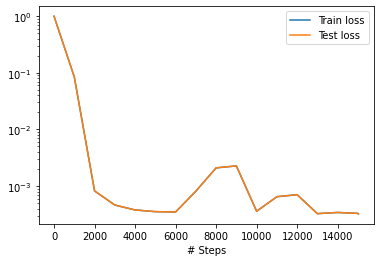

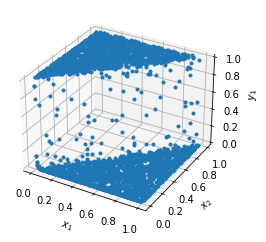

In [51]:
class PINN(object):
    def __init__(self, x_domain, t_domain, left_bc, ic, pde, 
        N_domain, N_boundary, N_initial, 
        NN_topology, NN_activation, NN_init):

        geom = dde.geometry.Interval(*x_domain)
        timedomain = dde.geometry.TimeDomain(*t_domain)
        geomtime = dde.geometry.GeometryXTime(geom, timedomain)

        bc = dde.icbc.DirichletBC( geomtime, 
            lambda x: left_bc, 
            lambda x,on_boundary: on_boundary and np.isclose(x[0], x_domain[0])
        )

        ic_ = dde.icbc.IC( geomtime, ic, lambda _, on_initial: on_initial )

        data = dde.data.TimePDE(
            geomtime, pde, [bc, ic_], num_domain=N_domain, num_boundary=N_boundary, num_initial=N_initial
        )

        net = dde.nn.FNN(NN_topology, NN_activation, NN_init)
        self.model = dde.Model(data, net)

    def train(self, NN_optimizers, NN_lr, NN_epochs):
        l = NN_optimizers.__len__()-1
        for i, (opt, lr, epoch) in enumerate(zip(NN_optimizers, NN_lr, NN_epochs)):
            self.model.compile(opt, lr=lr)
            if i == l:
                self.losshistory, self.train_state = self.model.train(epochs=epoch)
            else:
                self.model.train(epochs=epoch)
    
    def plotTrain(self):
        dde.saveplot(self.losshistory, self.train_state, issave=True, isplot=True)

def f_concave(u):
    return u/(u+(1-u)/M)

def f_convex(u):
    return u**2

def f_nonconvex(u):
    return u**2.0/(u**2.0+(1.0-u)**2.0/M)


fluxes = {'concave': {'f':f_concave, 'M':2},
        'convex': {'f':f_convex, 'M':1},
        'nonconvex': {'f':f_nonconvex, 'M':1} }

def tpf_pde(x, u):
    du_t = dde.grad.jacobian(u, x, i=0, j=1)
    df_u = dde.grad.jacobian(flux(u), u, i=0, j=0)
    du_x = dde.grad.jacobian(u, x, i=0, j=0)
    du_xx = dde.grad.hessian(u, x, i=0, j=0)
    return du_t + df_u*du_x - eps*du_xx

x_domain = (0, 1)
t_domain = (0, 0.99)
eps = 5.5e-3
left_bc = 1
ic = lambda x: np.zeros_like(x[:,0])
N_domain = 2540
N_boundary = 80
N_initial = 160
NN_topology = [2] + [32]*3 + [1]
NN_activation = "tanh"
NN_init = "Glorot normal"
NN_optimizers = ['adam', 'L-BFGS']
NN_epochs = [15000, None]
NN_lr = [1e-3, None]

flux = f_convex
M = 1
pde = tpf_pde

pinn = PINN(x_domain, t_domain, left_bc, ic, pde, 
            N_domain, N_boundary, N_initial, 
            NN_topology, NN_activation, NN_init)

pinn.train(NN_optimizers, NN_lr, NN_epochs)

pinn.plotTrain()

In [55]:
import twoPhaseFlow as tpf

def solve_exact(f, x, t, M):
    # f = tpf.u_convex
    u = tpf.u_solve(f, x, t, M)

    u = u.flatten()
    u = u.reshape((len(u),1))

    t_ = np.ones(len(u))
    t = chunks_multiply(t_, N, t)

    X = np.zeros_like(t)
    X = chunks_copy(X, N, x)

    X = np.stack((X,t),axis=1)

    return X, u
    

N = 256
x_ = np.linspace(0, 1, N)
Nt = 100
t_ = np.linspace(0, 0.99, Nt)
X, y_true = solve_exact(tpf.u_nonconvex, x_, t_, M)

y_pred = pinn.model.predict(X)
f = pinn.model.predict(X, operator=pde)
print("Mean residual:", np.mean(np.absolute(f)))
print("L2 relative error:", dde.metrics.l2_relative_error(y_true, y_pred))
np.savetxt("test.dat", np.hstack((X, y_true, y_pred)))


TypeError: 'int' object is not callable